Main.FractionalTransientStokes

In [78]:
module FractionalTransientStokes
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using Printf
using SpecialFunctions
using Triangulate
using DelimitedFiles
using SimplexGridFactory
using Triangulate
# include("../src/flowdata.jl")
function get_flow_data(ν, α=1.0, tp=1.0)
    ## note that dependencies "XT" marks the function to be x- and t-dependent
    ## that causes the solver to automatically reassemble associated operators in each time step
    u = DataFunction((result, x, t) -> (
        result[1] = 3*t^tp*(x[1]+x[2]); 
        result[2] = -3*t^tp*(x[1]+x[2]);
        ), [2,2]; name = "u", dependencies = "XT", bonus_quadorder = 5)
    u_t = DataFunction((result, x, t) -> (
        result[1] =  3*gamma(tp+1)/gamma(tp-α+1)*t^(tp-α)*(x[1]+x[2]); 
        result[2] = -3*gamma(tp+1)/gamma(tp-α+1)*t^(tp-α)*(x[1]+x[2]);
        ), [2,2]; name = "u", dependencies = "XT", bonus_quadorder = 5)
    p = DataFunction((result, x) -> (
        result[1] = 0.0
        ), [1,2]; name = "p", dependencies = "X", bonus_quadorder = 5)
  
    ############## common code for all examples #####
    dt_u = eval_dt(u)
    Δu = eval_Δ(u)
    ∇u = eval_∇(u)
    ∇p = eval_∇(p)
    f = DataFunction((result, x, t) -> (
        result .= u_t(x,t) .- ν*Δu(x,t) .+∇u(x,t)*u(x,t) .+ view(∇p(x,t),:);
        ), [2,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)  
    return u, p, f
end

function main(; α=1.0, tpower=1.0, ν=1.0, verbosity=0, nlevels=2, nsteps=10, T0=0, Tf=1.0, graded=false)
  set_verbosity(verbosity)
  ## initial grid 
  #xgrid = grid_unitsquare(Triangle2D)
  # refine the grid 
  #xgrid = uniform_refine(xgrid, nlevels)  
  xgrid = simplexgrid(Triangulate;
            points=[0 0 ; 0 1 ; 1 1 ; 1 0]',
            bfaces=[1 2 ; 2 3 ; 3 4 ; 4 1 ]',
            bfaceregions=[1, 2, 3, 4],
            regionpoints=[0.5 0.5;]',
            regionnumbers=[1],
            regionvolumes=[4.0^(-nlevels-1)/2])
  println(xgrid)

  ## choose one of these (inf-sup stable) finite element type pairs
  FETypes = [H1P2{2,2}, H1P1{1}] # Taylor-Hood elements
  # flow data 
  u, p, f= get_flow_data(ν)
  # generate FE spaces
  FES = [FESpace{FETypes[1]}(xgrid), FESpace{FETypes[2]}(xgrid)]
  # solution vector
  Solution = FEVector(["u_h", "p_h"], FES)
  res = FEVector(["u_h", "p_h"], FES)  

  ndofu = FES[1].ndofs
  ndofp = FES[2].ndofs
  GradientRobustMultiPhysics.interpolate!(Solution[1], u; time = 0.)

  # mass matrix 
  M = FEMatrix{Float64}(FES)
  assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
  # velocity pressure matrices
  A = FEMatrix{Float64}(FES)
  assemble_operator!(A[1,1], LaplaceOperator(ν))
  assemble_operator!(A[1,2], LagrangeMultiplier(Divergence); At = A[2,1]) 

  rhs = FEVector{Float64}(FES)
  assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)

  dt = Array{BoundaryData,1}(undef,0)
  push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
  dofs = boundarydata!(Solution[1], dt; time = 0.0)
  # preparation of time stepping scheme
  # L1-Scheme and Graded L1-Scheme
  aj = zeros(nsteps)
  aj[1] = 1.0;
  for j = 2:nsteps 
    aj[j] = j^(1-α) - (j-1)^(1-α)
  end
  @show aj
  bj = zeros(nsteps+1)
  bj[1] = aj[1]
  bj[nsteps+1] = -aj[nsteps]
  for j=2:nsteps 
    bj[nsteps-j+2]= aj[nsteps-j+2] - aj[nsteps-j+1]
  end
  @show bj
  temp = sum(bj)
  @info temp
  tau = (Tf-T0)/nsteps
  # Declaration: system matrices and rhs
  V1 = zeros(Float64, ndofu, 1)
  Mu0 = zeros(Float64, ndofu)
  
  SolVect = zeros(Float64, ndofu, nsteps)    
  SolVect[:, 1] = Solution[1][:]

  SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
  SystemRHS = FEVector(FES)
  SystemSol = FEVector(FES)  

  scale = tau^α*gamma(2-α)
  if graded
    @info "not yet implemented"
  end
  ###
    ## time loop 
  ###
  t0 = T0;
  Mu0 = M.entries*Solution[1].entries
  l2 = zero(Float64)
  for m=2:nsteps 
    t0 = t0 + tau
    fill!(SystemRHS.entries, 0)
    fill!(rhs.entries, 0)
    assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
    V1[:, 1] = rhs[1][:]
    addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
    addblock!(SystemRHS[1], Mu0; factor= aj[m-1]/scale)
    for j=2:m-1
      #   println(m," ", j, " ", m-j+1, " ", bj[m-j+1])
      temp = zeros(Float64, ndofu)
      addblock_matmul!(temp, M[1,1], SolVect[:, j])
      # addblock!(SystemRHS[1], M[1,1].entries*SolVect[:, j]; factor= -bj[m-j+1]/scale)
      addblock!(SystemRHS[1],temp; factor= -bj[m-j+1]/scale)
    end

    fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
    fill!(A[1,1], 0)
    assemble_operator!(A[1, 1], LaplaceOperator(ν); time=t0 )
    addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/scale)
    # adding velocity and pressure blocks to the system matrix
    addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
    addblock!(SystemMatrix[1, 2], A[1, 2]; factor= 1.0)
    addblock!(SystemMatrix[2, 1], A[2, 1]; factor= 1.0)
    addblock!(SystemMatrix[2, 2], A[2, 2]; factor= 1.0)

    flush!(SystemMatrix.entries)
    dofs = boundarydata!(SystemSol[1], dt; time = t0)
    for dof in dofs
      SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
      SystemMatrix[1,1][dof,dof] = 1e60
    end
    SystemMatrix[2,2][1,1] = 1e60 #pressure correction      
    SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
    
    for j = 1 : ndofu 
      Solution[1][j] = SystemSol[1][j]
    end
    
    SolVect[:, m] = Solution[1][:]
    
    L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
    l2 = evaluate(L2Error_u, Solution[1])
    # @show m, sqrt(l2)
  end
  @info sqrt(l2)
  (sqrt(l2))
  #println("done", temp)
end
end

Main.FractionalTransientStokes

In [79]:
ns = [4 8 16 32 64]
eL2=[]; eH1=[];
for n in ns
    el2 = Main.FractionalTransientStokes.main(nsteps=n, α=1, tpower=1)
    push!(eL2, el2)
    #push!(eH1, eh1)
end
# Main.FractionalTransientStokes.main(nsteps=64; α=0.1, tpower=1, graded=false)

ExtendableGrids.ExtendableGrid{Float64, Int32};
dim: 2 nodes: 115 cells: 194 bfaces: 34




aj = [1.0, 0.0, 0.0, 0.0]
bj = [1.0, -1.0, 0.0, 0.0, -0.0]
[ Info: 0.0


[ Info: 2.5936463855341603e-15
ExtendableGrids.ExtendableGrid{Float64, Int32};
dim: 2 nodes: 115 cells: 194 bfaces: 34


aj = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
bj = [1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]


[ Info: 0.0
[ Info: 3.0041145499445e-15
ExtendableGrids.ExtendableGrid{Float64, Int32};
dim: 2 nodes: 115 cells: 194 bfaces: 34


aj = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
bj = [1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]
[ Info: 0.0


[ Info: 3.5220482435814767e-15
ExtendableGrids.ExtendableGrid{Float64, Int32};
dim: 2 nodes: 115 cells: 194 bfaces: 34


aj = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
bj = [1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]


[ Info: 0.0
[ Info: 3.646206177717875e-15
ExtendableGrids.ExtendableGrid{Float64, Int32};
dim: 2 nodes: 115 cells: 194 bfaces: 34


aj = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
bj = [1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]
[ Info: 0.0


[ Info: 3.4100437328342134e-15


L2: Any[2.5936463855341603e-15, 3.0041145499445e-15, 3.5220482435814767e-15, 3.646206177717875e-15, 3.4100437328342134e-15]


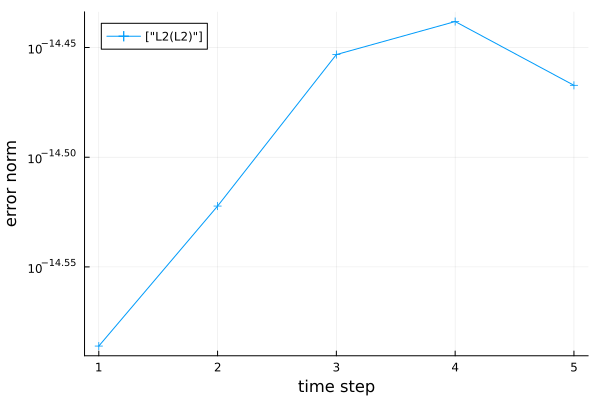

In [80]:
using Plots
println("L2: ", eL2)
taus = [ 1,2,3,4,5]
plot(taus,[eL2],
    yaxis=:log10,
    label=["L2(L2)" ],
    shape=:auto,
    xlabel="time step",ylabel="error norm")